# Homework 4 - Group 10

## Our team:

- Giulia Scikibu Maravalli
- Katsiaryna Zavadskaya
- Sara Cordaro 

*Libraries*:

In [15]:
# libraries
from requests import get
from bs4 import BeautifulSoup
import time
import pandas as pd
import os
import nltk # to clean the file
from nltk.stem import PorterStemmer # for stemming
import math
import numpy as np
import string
from collections import defaultdict
import matplotlib.pyplot as plt
import json
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import pickle
import random
from sklearn.cluster import KMeans
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

## 1) Does basic house information reflect house's description?  
In this assignment we will perform a clustering analysis of house announcements in Rome from [Immobiliare.it](https://www.immobiliare.it/).  

### Scraping  & Datasets

Retrieving at least 10k announcements from *Immobiliare.it*, we created our dataset.
Let's see how!  

In our **main function**, we connect to the website (with our function **html_soup**, where we used *Beautiful Soup* library) and we iterate through its pages (every page contain 25 announcements) until we have processed at least 10 thousand announcements. Every time we pick an announcement we perform the following operations:

- check if all the information we need are present (i.e. price, local, bathroom, floor, surface), otherwise we skip this announcement, and go to the next. To take these information we used **take_info** function.  


- if we find the information above, we take the link of this announcement, and verify if there is the description (if not the house has been removed and we can go over it as well). To take description we used **take_description** function.


- after we took the description, we processed it as a string: remove escape, punctuation and italian stopwords(this operation is executed by **clean_text** function). At the end of this cleaning, we save the modified description inside a new file, called *desc_n.txt* (where *n* is the number of the announcement). (**desc_file** function will do this).


- At this point, if the announcement has both the required fields and description, we save every field in a dedicated list (look at the chunck of global variables, we create a list for each field).  

And finally, we have our dataframes.

In [2]:
# global variables

# seconds to wait, to prevent the website block
t = .400

# url main
immobiliare_link = 'https://www.immobiliare.it'

# total number of announcements
N = 10000

# list of announcement's links
link = []
# list of announcement's prices
price = []
# list of announcement's locals
local = []
# list of announcement's surfaces
surface = []
# list of announcement's bathrooms
bathroom = []
# list of announcement's floors
floor = []
# list of announcement's numbers
number = []
# list of number of words
doc_num_words = []

# number of announcements
num_announcement = 1
# page of announcements
page = 1


# dictionary (key: word, value: list of idx repeat for the number of time that the word appears)
dic_words = defaultdict(list)

# dictionary (key: word, value: tfidf for each announcement)
tfidf_dic = defaultdict(list)

# escape
escape = r'\n'
# set punctuation
set_punt = list(string.punctuation)
# set stopwords
stop_words = set(nltk.corpus.stopwords.words('italian'))
# stemming
ps = PorterStemmer()
# main path
main_path = 'C:/Users/giuli/Desktop/AMD_HW4'

In [3]:
# function to clean the description (to remove punctuation and /n)
def clean_text(text):
    text = text.replace(escape, ' ')
    # split description in a list
    list_txt = text.split(' ')
    # list of clean words
    new_words = []
    # iterate each word of description
    for word in list_txt:
        if word.isalpha():
            if word not in set_punt:
                # take each char in the string
                for c in word:
                    # delete char if it is a punctuation
                    if c in set_punt:
                        word = word.replace(c,"")
                # save the string only if it isn't a stop words
                if word not in stop_words: 
                    # we save the word in lowercase - so it is easier work in this way
                    word = word.lower()
                    new_words.append(word)
    # convert description in strings
    new_desc = ' '.join(new_words)
    return new_desc
        

In [4]:
def desc_file(idx,text):
    text = clean_text(text)
    # create a new folder where we save cleaned file
    if not os.path.exists(main_path):
        os.mkdir(main_path)
    # create a file
    with open(main_path + "/desc_" +str(idx) + ".txt", "w") as f:
        # write description
        f.write(text)
    return

In [5]:
# html document
def html_soup(url):
    # request the server the content of the web page and store the server’s response - html document
    while True:
        try:
            response = get(url)
            html_soup = BeautifulSoup(response.text, 'html.parser')
            return html_soup
        except:
            time.sleep(t)
            continue

In [6]:
# take description of each valid announcement
def take_description(url_home,num):  
    try:
        html_home = html_soup(url_home)
        desc_home = html_home.find('div', class_ ="col-xs-12 description-text text-compressed").text
        desc_file(num,desc_home)
        return True
    except:
        return False

In [7]:
def take_info(announcement_info):
    # try if the informations are not NONE
    try:
        infos = []
        # take price of the home
        price_info = announcement_info.find('li', class_="lif__item").text
        # clean the price
        price_info = price_info.strip()        
        if price_info.count("€") >= 2:
            price_info = "€ " + ''.join(price_info.split("€ ", 2)[:2])
        # verify if it is only one home or a group of home
        if 'da' not in price_info:
            infos.append(price_info)
            # take the other informations
            all_info = announcement_info.find_all('div', class_ = "lif__data")
            # save the other informations
            for info in all_info[:-1]:
                infos.append(info.span.text)
            # take the home's floor    
            info_floor = all_info[-1].find('abbr')['title']
            infos.append(info_floor)
            return infos
    # if there are some informations NONE    
    except:
        infos = []
        return infos



In [8]:
#MAIN FUNCTION

start_time = time.time()


# we want to analyze the info's on https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=1
# to retrieve at least 10k announcements
while num_announcement <= N:
    # assign the address of the web page to a variable named url
    url = immobiliare_link + '/vendita-case/roma/?criterio=rilevanza&pag=' + str(page)
    html_announcements = html_soup(url)    
    # exctract all informations for each announcement
    announcements_info = html_announcements.find_all('ul', class_ ="listing-features list-piped")
    # extract all the div containers that have a class attribute of listing-item_body--content - result set
    announcements_link = html_announcements.find_all('div', attrs={'class':'listing-item_body--content'})
    # iterate each list of home's informations
    for index in range(len(announcements_info)):
        # take information of announcement
        infos = take_info(announcements_info[index])
        # check if there are all informations
        if infos != None and (len(infos) == 5):
            # take the home's link
            home_link = announcements_link[index].a['href']
            if immobiliare_link not in home_link:
                home_link = immobiliare_link + home_link
            # take description link of a home and control if the home is valid
            control = take_description(home_link, num_announcement)
            # if the home has the description is valid
            if control == True:
                # save all informations of a valid home in the global variables
                link.append(home_link)
                price.append(infos[0])
                local.append(infos[1])
                surface.append(infos[2])
                bathroom.append(infos[3])
                floor.append(infos[4])
                number.append(int(num_announcement))
        num_announcement += 1
    page += 1
    
end_time = time.time()
print(end_time - start_time)    

6348.990574359894


In [9]:
# create dataframe 1
df_1 = pd.DataFrame({'Price': price,
                       'Local': local,
                       'Surface': surface,
                       'Bathroom': bathroom,
                       'Floor': floor}, index = number)

In [10]:
df_1.head()

,Price,Local,Surface,Bathroom,Floor
2,€ 225.000,2,50,1,1
3,€ 400.000,3,60,1,3
4,€ 500.000,3,89,2,3
5,€ 574.000,4,89,2,5
6,€ 300.000,2,46,1,4


We saved the dataframe with all required fields to a .csv file:

In [11]:
# save the dataframe 1 in a file csv
df_1.to_csv(main_path+'/matrix_1.csv')

Since we want to build from this dataframe a real matrix, we need to filter it:

In [18]:
# filter dataframe to create matrix_1

# prices clean
price_clean = []
for p in price:
    p = p.replace('€ ','')
    p = p.replace(escape,'')
    p = p.replace('.','')
    price_clean.append(p)
    
# locals clean 
local_clean = []
for l in local:
    l = l.replace('+','')
    local_clean.append(int(l))

# surfaces clean
surface_clean = []
for s in surface:
    s = s.replace('.','')
    surface_clean.append(int(s))

# bathrooms clean
bath_clean = []
for b in bathroom:
    b = b.replace('+','')
    bath_clean.append(int(b))

data_1 = pd.DataFrame({'Price': price_clean,
                       'Local': local_clean,
                       'Surface': surface_clean,
                       'Bathroom': bath_clean,
                       'Floor': floor})

data_1 = data_1[data_1.Price.apply(lambda x: x.isdigit())]
data_1 = data_1[data_1['Local'].apply(lambda x: (str(x)).isdigit())]
data_1 = data_1[data_1['Surface'].apply(lambda x: str(x).isdigit())]
data_1 = data_1[data_1['Bathroom'].apply(lambda x: (str(x)).isdigit())]
data_1 = data_1[data_1['Floor'].apply(lambda x: (str(x)).isdigit())]

In [19]:
data_1.head()

,Price,Local,Surface,Bathroom,Floor
0,225000,2,50,1,1
1,400000,3,60,1,3
2,500000,3,89,2,3
3,574000,4,89,2,5
4,300000,2,46,1,4


In [20]:
# create matrix 1
matrix_1 = data_1.values
matrix_1 = np.matrix(matrix_1).astype(float)

We save the obtained matrix into a .csv file:

In [22]:
# save the matrix 1 in a file txt
np.savetxt('last_matrix_1.txt', matrix_1, delimiter=",")

Now after we have built the first dataframe, we need to create the second one. In order to do so, we first iterate through all the *desc_n.txt* created before and for each of them, we stem all the words in the file and store the number of words in *doc_num_words* list. At the end of iteration we create a new file, called *vocabulary.txt* where we save a dictionary containing as keys the word and as value a list that have the index of the announcement in which that word appeared (if the word appears muliple times in an announcement, that index will be repeated). 

In [12]:
# create vocabularies
# iterate the files
for idx in number:
    with open(main_path + "/desc_" +str(idx)+ ".txt") as f:
        # split the line according to '\t'
        line = f.read()
        list_file = line.split(' ')
        # save the word as key and the index of the file in list of values
        for word in list_file:
            # stemming
            word = ps.stem(word)
            dic_words[word].append(idx)
        num_words = len(list_file)
        doc_num_words.append(num_words)
# save dictionary in a file
with open(main_path +'/vocabulary.txt', 'w') as f:
        f.write(json.dumps(dic_words))

Now we compute *tf-Idf* and built the second matrix in the format requested:

In [13]:
# function that returns the tfIdf (announcement, word)
def compute_tfIdf(word, idx , voc):
    # tf is term frequences on a determinate description
    tf =(voc[word].count(number[idx]))/(doc_num_words[idx])
    # df document frequences
    df = len(set(voc[word]))
    # idf inverse document frequency
    idf = math.log10(len(number)/df)
    return(tf*idf)

In [14]:
# open and save vocabulary
vocabulary = json.load(open(main_path +'/vocabulary.txt', 'rb'))
list_words = sorted(list(vocabulary.keys()))
for word in list_words:
    for idx in range(len(number)):
        tfidf = compute_tfIdf(word,idx,vocabulary)
        tfidf_dic[word].append(tfidf)

We store the result in a dataframe, and then save it as .csv and .txt (as a matrix) files.

In [15]:
# create dataframe 2
df_2 = pd.DataFrame(data = tfidf_dic, index = number)
    

In [16]:
df_2.head()

,a,aabbiamo,ab,abacu,abamelek,abano,abb,abba,abbaini,abbaino,...,élégant,énergétiqu,équipé,étage,état,étude,été,ìntegrata,último,über
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# save the dataframe 2 in a file csv
df_2.to_csv(main_path+'/matrix_2.csv')

In [21]:
# create matrix 2
matrix_2 = df_2.values
matrix_2 = np.matrix(matrix_2).astype(float)

In [23]:
# save the matrix 2 in a file txt
np.savetxt('last_matrix_2.txt', matrix_2, delimiter=",")

We also save the list of announcement's number because it will be useful in next steps.

In [17]:
#save list of announcement's number
with open('list', 'wb') as fp:
    pickle.dump(number, fp)

### Clustering

This step consists in clustering the house announcements using K-means++ algorithm. In order to do that, we used KMeans Python library. As K-means++ algorithm requires to insert k - number of desired clusters, firstly we choose the optimal number of clusters using the Elbow-Method.

Importing Information matrix and assigning announcement id as row index.

In [2]:
inf_matrix = pd.read_csv('matrices/matrix_1.csv')
inf_matrix = inf_matrix.set_index('Unnamed: 0')

In [3]:
inf_matrix.head()

,Price,Local,Surface,Bathroom,Floor
Unnamed: 0,,,,,
2,€ 225.000,2,50.0,1,1
3,€ 400.000,3,60.0,1,3
4,€ 500.000,3,89.0,2,3
5,€ 574.000,4,89.0,2,5
6,€ 300.000,2,46.0,1,4


Filtering information matrix from undesired symbols and dropping rows with incomplete data.

In [4]:
escape = r'\n'
price_clean = []
for p in inf_matrix.Price:
    p = p.replace('€ ','')
    p = p.replace(escape,'')
    p = p.replace('.','')
    price_clean.append(p)
    
# locals clean 
local_clean = []
for l in inf_matrix.Local:
    l = l.replace('+','')
    local_clean.append(int(l))
    
# surfaces clean
surface_clean = []
for s in inf_matrix.Surface:
    s = str(s)
    s = s.replace('.','')
    surface_clean.append(int(s))

# bathrooms clean
bath_clean = []
for b in inf_matrix.Bathroom:
    b = b.replace('+','')
    bath_clean.append(int(b))
    
inf_matrix = pd.DataFrame({'Price': price_clean,
                       'Local': local_clean,
                       'Surface': surface_clean,
                       'Bathroom': bath_clean,
                       'Floor': inf_matrix.Floor})

inf_matrix = inf_matrix[inf_matrix.Price.apply(lambda x: x.isdigit())]
inf_matrix = inf_matrix[inf_matrix.Local.apply(lambda x: (str(x)).isdigit())]
inf_matrix = inf_matrix[inf_matrix.Surface.apply(lambda x: str(x).isdigit())]
inf_matrix = inf_matrix[inf_matrix.Bathroom.apply(lambda x: (str(x)).isdigit())]
inf_matrix = inf_matrix[inf_matrix.Floor.apply(lambda x: (str(x)).isdigit())]

In [6]:
column_names = list(inf_matrix.columns)

Choosing the optimal number of clusters using Elbow Method.  As we can see on the graph below, there are two possible values for number of clusters: 3 and 4, but since SSD (Sum of squared distances) varies stronger between 2 and 3 and not between 3 and 4, we choose 3 as the most reasonable number of clusters for informational matrix.

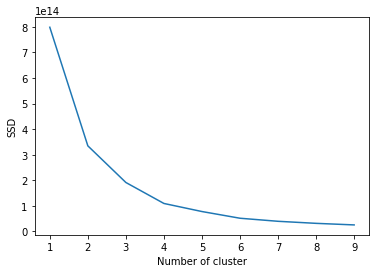

In [8]:
distance = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000).fit(inf_matrix)
    inf_matrix["clusters"] = kmeans.labels_ # Index of the cluster each sample belongs to.
    distance[k] = kmeans.inertia_ # Sum of squared distances of samples to their closest cluster center.
plt.figure()
plt.plot(list(distance.keys()), list(distance.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSD") # Sum of squared distances 
plt.show()

In [10]:
inf_matrix = inf_matrix.drop(['clusters'], axis=1)

Below we perform clustering using k-means++ method, inserting our chosen number of clusters = 3. cl_ind is a list of clusters' indexes. cluster_centers_inf is a data frame for saving clusters centers.

In [11]:
# create kmeans object
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=1000)
# fit kmeans object to data
kmeans.fit(inf_matrix)
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# prediction of cluster index for each sample
cl_ind = kmeans.fit_predict(inf_matrix)

[[  1.37898551e+00   2.58188406e+00   2.97657005e+00   2.62918476e+05
    8.79024155e+02]
 [  2.12462462e+00   2.83258258e+00   4.31231231e+00   6.91317192e+05
    1.52015766e+03]
 [  2.66159696e+00   2.93536122e+00   4.76806084e+00   1.66376046e+06
    2.41057034e+03]]


In [15]:
inf_matrix['cl_ind'] = cl_ind # index of cluster to whuch sample belongs
cluster_centers_inf = pd.DataFrame(data = kmeans.cluster_centers_,columns = column_names)
cluster_centers_inf['cl_ind'] = np.unique(cl_ind)

cluster_centers_inf

,Bathroom,Floor,Local,Price,Surface,cl_ind
0,1.389112,2.589586,2.995503,2.673767e+05,886.139645,0
1,2.695279,2.969957,4.793991,1.724142e+06,2482.446352,1
2,2.147220,2.819890,4.344558,7.169103e+05,1547.094753,2


In [16]:
inf_matrix.head()

,Bathroom,Floor,Local,Price,Surface,cl_ind
Unnamed: 0,,,,,,
2,1,1,2,225000,500,0
3,1,3,3,400000,600,0
4,2,3,3,500000,890,2
5,2,5,4,574000,890,2
6,1,4,2,300000,460,0


Below we provide visual representation of our clusters, as we have 5 features which describe our data sample, we decided to show them separately.   
First graph is for showing our 3 clusters according to price in the announcment, while others are for all other columns respectively. Another colour represents centeres of clusters.

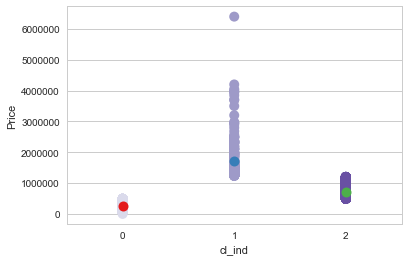

In [17]:
sns.set(style="whitegrid")
ax = sns.stripplot(x="cl_ind", y="Price", data=inf_matrix, palette="Purples", size=10)
ax = sns.stripplot(x="cl_ind", y="Price", data=cluster_centers_inf, palette="Set1", size=10)
plt.show()

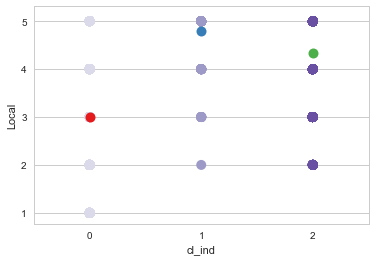

In [18]:
ax = sns.stripplot(x="cl_ind", y="Local", data=inf_matrix, palette="Purples", size=10)
ax = sns.stripplot(x="cl_ind", y="Local", data=cluster_centers_inf, palette="Set1", size=10)
plt.show()

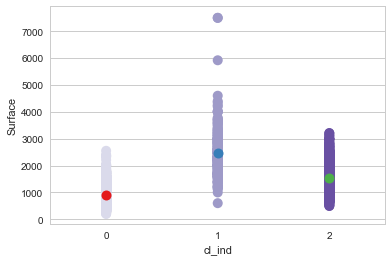

In [19]:
ax = sns.stripplot(x="cl_ind", y="Surface", data=inf_matrix, palette="Purples", size=10)
ax = sns.stripplot(x="cl_ind", y="Surface", data=cluster_centers_inf, palette="Set1", size=10)
plt.show()

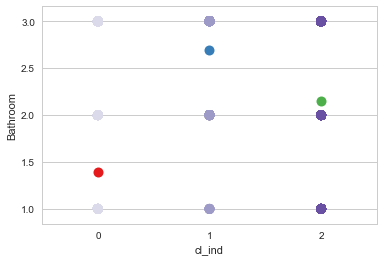

In [20]:
ax = sns.stripplot(x="cl_ind", y="Bathroom", data=inf_matrix, palette="Purples", size=10)
ax = sns.stripplot(x="cl_ind", y="Bathroom", data=cluster_centers_inf, palette="Set1", size=10)
plt.show()

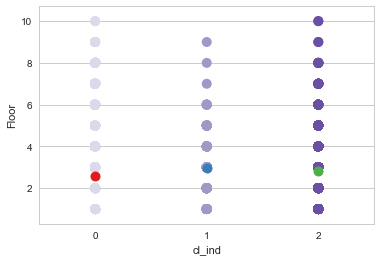

In [21]:
ax = sns.stripplot(x="cl_ind", y="Floor", data=inf_matrix, palette="Purples", size=10)
ax = sns.stripplot(x="cl_ind", y="Floor", data=cluster_centers_inf, palette="Set1", size=10)
plt.show()

Here we are clustering using k-means++ Description matrix. Same as in the previous part, firstly we choose optimal number of clusters and then perform clustering.

In [23]:
desc_matrix = pd.read_csv('matrices/matrix_2.csv')
desc_matrix = desc_matrix.set_index('Unnamed: 0')

desc_matrix.head()

,a,aabbiamo,ab,abacu,abamelek,abano,abb,abba,abbaini,abbaino,...,élégant,énergétiqu,équipé,étage,état,étude,été,ìntegrata,último,über
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here on graph we can see that the only optimal value for number of clusters is two, as SSD is significantly differs between 1 and 2, when it comes to 3 or more clusters, SSD is practically the same, it is shown on the graph below and also in distance dictionary. That's why for description matrix we choose k - number of clusters = 2.

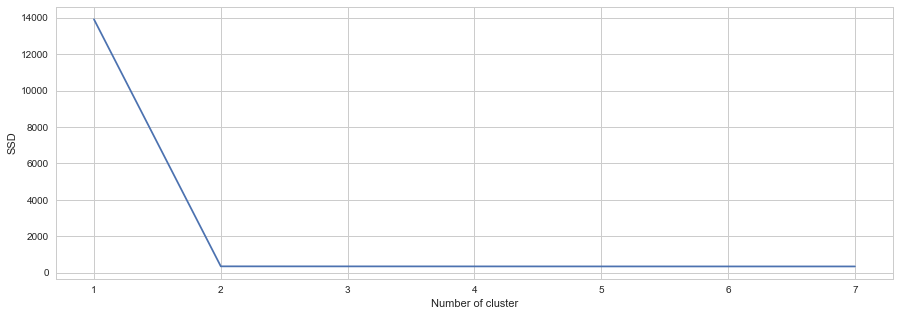

In [69]:
distance = {}
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, init='k-means++').fit(desc_matrix) 
    desc_matrix["clusters"] = kmeans.labels_ # Index of the cluster each sample belongs to. 
    distance[k] = kmeans.inertia_ # Sum of squared distances of samples to their closest cluster center.
plt.figure(figsize=(15,5))
plt.plot(list(distance.keys()), list(distance.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSD") # Sum of squared distances 
plt.show()

In [70]:
distance

{1: 13912.261614815779,
 2: 345.65877565843874,
 3: 344.02504188926343,
 4: 342.63508317391899,
 5: 341.39649087516318,
 6: 340.69500906314789,
 7: 340.1535108612124}

Graph for k equals from 2 to 7.

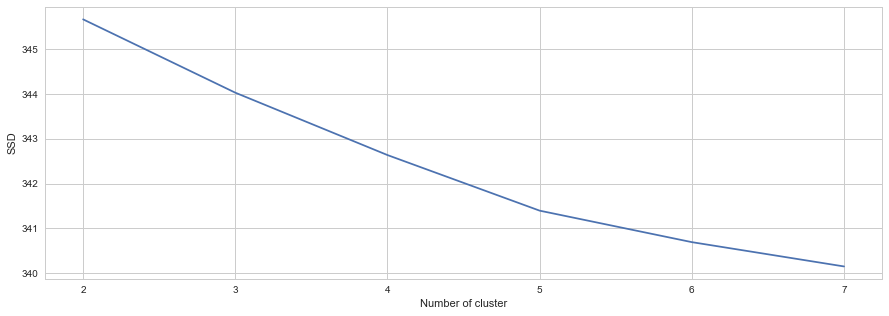

In [71]:
plt.figure(figsize=(15,5))
plt.plot(list(distance.keys())[1:], list(distance.values())[1:])
plt.xlabel("Number of cluster")
plt.ylabel("SSD") # Sum of squared distances 
plt.show()

Performing k-means++ algorithm for description matrix. We are not going to plot clusters for this matrix as it has too many features.

In [72]:
# create kmeans object
kmeans = KMeans(n_clusters=2, init='k-means++')
# fit kmeans object to data
kmeans.fit(desc_matrix)
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# prediction of cluster index for each sample
cl_ind = kmeans.fit_predict(desc_matrix)

[[  1.50325894e-03   1.53676877e-05  -6.57297567e-19 ...,   4.33447601e-06
    1.21695868e+00   2.62984079e-15]
 [  2.09858830e-03  -1.76182853e-19   2.01781847e-05 ...,   2.20228566e-20
    4.16628109e+00   1.15673800e-01]]


In [74]:
desc_matrix['cl_ind'] = cl_ind # index of cluster to whuch sample belongs

cluster_centers_inf = pd.DataFrame(data = kmeans.cluster_centers_)

cluster_centers_inf['cl_ind'] = np.unique(cl_ind)

cluster_centers_inf

,0,1,2,3,4,5,6,7,8,9,...,15564,15565,15566,15567,15568,15569,15570,15571,15572,cl_ind
0,0.002099,-1.761829e-19,2.017818e-05,-1.368805e-18,1.822546e-05,1.738428e-05,-5.082198e-21,2.473336e-19,0.000013,0.000019,...,0.000113,-2.219226e-19,2.092552e-05,-1.215492e-19,1.228237e-05,4.065758e-20,2.202286e-20,4.166281,1.156738e-01,0
1,0.001503,1.536769e-05,-6.572976e-19,6.475728e-05,3.828589e-19,1.270549e-20,4.857602e-06,3.674882e-05,0.000008,0.000014,...,0.000029,1.052862e-05,2.015938e-19,4.843684e-06,-2.905323e-19,2.744230e-06,4.334476e-06,1.216959,2.629841e-15,1


## Comparison among cluster

Find similar clusters. To check this we use the Jaccard-Similarity to measure the similarity betweeen the two outputs (information clusters vs description clusters) and then we return the 3-most similar couples of clusters.  
To find similarity between clusters we need to compare each pair of clusters. For example, first cluster from information data with first and second from description data.  
To do that we use formula: intersection(clusters) / union(clusters). To find this we need announcement's id-s which belong to each cluster.  
Now for each of matrices we are saving announcement’s id-s for each cluster.

In [75]:
m1_indexes = []
for i in range(len(np.unique(inf_matrix.cl_ind))):
    m1_indexes.append(list(inf_matrix[inf_matrix.cl_ind == i].index.values))

In [76]:
print(m1_indexes[1]) #announcements in second cluster of informational data

[25, 35, 37, 43, 52, 58, 63, 66, 72, 76, 77, 85, 91, 105, 107, 108, 130, 131, 145, 154, 162, 175, 178, 181, 204, 206, 207, 227, 249, 291, 293, 296, 298, 301, 306, 313, 319, 330, 331, 332, 335, 337, 339, 368, 378, 381, 393, 438, 495, 496, 546, 547, 555, 653, 686, 696, 702, 907, 911, 925, 1077, 1079, 1104, 1138, 1180, 1189, 1206, 1247, 1281, 1317, 1678, 1735, 1761, 1763, 1840, 1851, 1889, 1948, 2067, 2076, 2104, 2117, 2150, 2232, 2254, 2274, 2284, 2491, 2531, 2569, 2584, 2647, 2700, 2704, 2706, 2717, 2718, 2741, 2767, 2995, 3003, 3004, 3007, 3008, 3021, 3121, 3157, 3185, 3239, 3279, 3327, 3368, 3370, 3377, 3432, 3436, 3474, 3534, 3567, 3578, 3589, 3610, 3625, 3683, 3806, 3902, 3986, 3995, 4037, 4053, 4065, 4136, 4164, 4214, 4341, 4355, 4372, 4406, 4412, 4444, 4575, 4638, 4653, 4753, 4926, 5049, 5061, 5154, 5237, 5397, 5498, 5529, 5531, 5542, 5628, 5634, 5670, 5804, 6091, 6136, 6138, 6163, 6262, 6284, 6286, 6296, 6391, 6411, 6428, 6525, 6543, 6604, 6615, 6655, 6658, 6732, 6733, 6778, 6804

In [78]:
m2_indexes = []
for i in range(len(np.unique(desc_matrix.cl_ind))):
    m2_indexes.append(list(desc_matrix[desc_matrix.cl_ind == i].index.values))

### Jaccard Similarity
Jaccard_Similarity is a data frame of similarity measures between information clusters and description clusters. Where columns are for informatiom clusters.

In [80]:
Jaccard_Similarity = pd.DataFrame(np.zeros((len(np.unique(desc_matrix.cl_ind)),len(np.unique(inf_matrix.cl_ind)))))
Jaccard_Similarity_dict = {}
Jaccard_Similarity

,0,1,2
0,0.0,0.0,0.0
1,0.0,0.0,0.0


In [81]:
for i in range(len(m1_indexes)):
    for j in range(len(m2_indexes)):
        val = len(set(m1_indexes[i]).intersection(set(m2_indexes[j]))) / len(set(m1_indexes[i]).union(set(m2_indexes[j])))
        Jaccard_Similarity[i][j] = val
        Jaccard_Similarity_dict[val] = (i,j)

In [82]:
Jaccard_Similarity

,0,1,2
0,0.360786,0.015406,0.104760
1,0.328529,0.037829,0.163249


Now when we have our similarity values we are looking for 3 most similar pairs of clusters

In [83]:
Jaccard_Similarity_dict

{0.015405777166437413: (1, 0),
 0.03782859585381492: (1, 1),
 0.10475968268782081: (2, 0),
 0.1632492113564669: (2, 1),
 0.32852852852852854: (0, 1),
 0.3607863974495218: (0, 0)}

In [86]:
Jaccard_Similarity_lst = list(Jaccard_Similarity_dict.keys())
Jaccard_Similarity_lst.sort(reverse=True)
Jaccard_Similarity_lst

[0.3607863974495218,
 0.32852852852852854,
 0.1632492113564669,
 0.10475968268782081,
 0.03782859585381492,
 0.015405777166437413]

Here we see our pairs of most similar clusters in format (information cluster id,description cluster id).

In [87]:
print(Jaccard_Similarity_dict.get(Jaccard_Similarity_lst[0]), Jaccard_Similarity_dict.get(Jaccard_Similarity_lst[1]), \
Jaccard_Similarity_dict.get(Jaccard_Similarity_lst[2]))

(0, 0) (0, 1) (2, 1)


### Word cloud of house descriptions

To create a word cloud for a pair of clusters we need union of announcements id-s in these clusters. Then using these id-s, we get announcements' descriptions.

In [88]:
# list of id-s for each cluster
cloud_doc_ids = []

for i in range(3):
    Jaccard_Similarity_dict.get(Jaccard_Similarity_lst[i])[0]
    cloud_doc_ids.append(list(set(m1_indexes[Jaccard_Similarity_dict.get(Jaccard_Similarity_lst[i])[0]]).\
                              union(set(m2_indexes[Jaccard_Similarity_dict.get(Jaccard_Similarity_lst[i])[1]]))))

In [89]:
word_clouds = [] # list of words for each cluster 
for i in range(len(cloud_doc_ids)):
    cloud = ''
    for elem in cloud_doc_ids[i]:
        with open('desc_files/desc_' + str(elem) + '.txt', 'r') as f:
            data = f.readlines()
 
            for line in data:
                words = line.split()
                cloud_string = ' '.join(words)
        cloud = cloud + ' ' + cloud_string
    word_clouds.append(cloud)

In [50]:
def word_clds(n):
    # Start with one review:
    text = word_clouds[n]

    #Create a mask
    mask = np.array(Image.open('C:/Users/giuli/Desktop/AMD_HW4/house.png'))

    # Create and generate a word cloud image:
    wordcloud = WordCloud(background_color='white', mask = mask, 
                          contour_width=3, contour_color='steelblue').generate(text)

    # Display the generated image:
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    
    return plt.show()

#### Word cloud for first pair of clusters

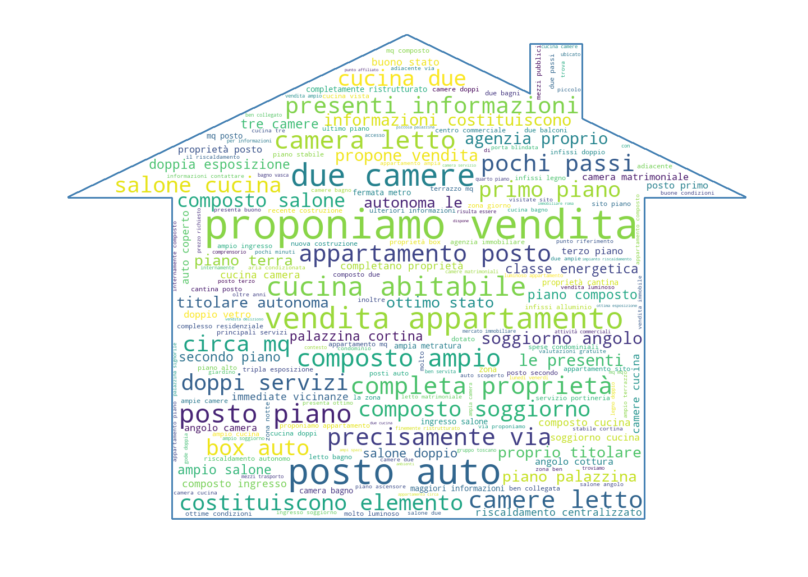

In [51]:
word_clds(0)

#### Word cloud for second pair of clusters

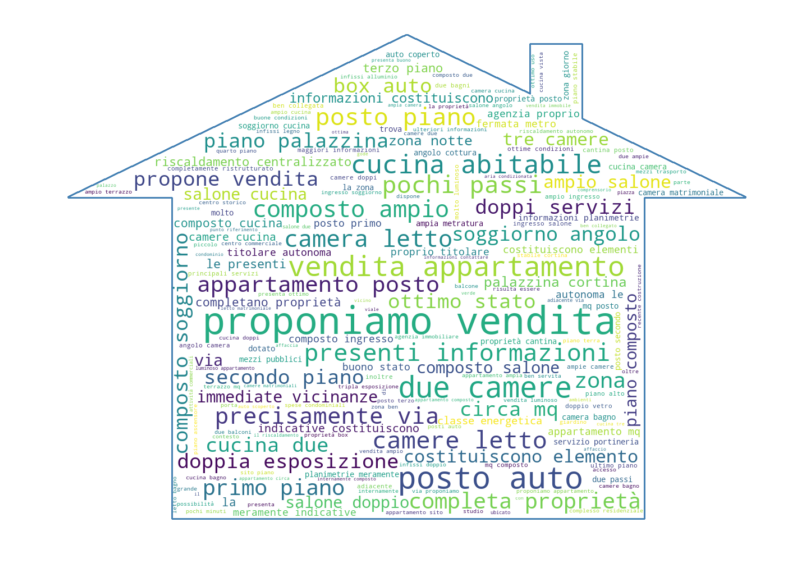

In [52]:
word_clds(1)

#### Word cloud for the third pair of clusters

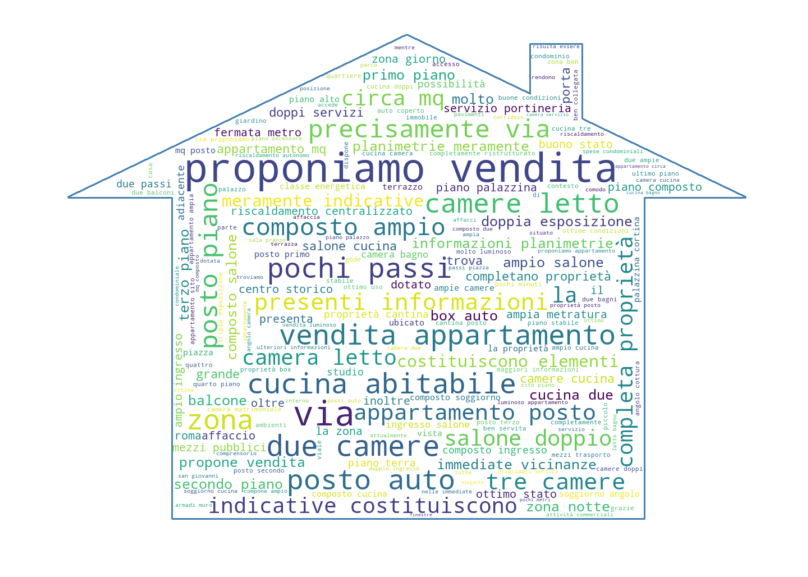

In [53]:
word_clds(2)

## Bonus Clustering

Now we make an analysis similar to the one did above, but this time we use a K-means algorithm defined by ourselves. K-means is an unsupervised learning algorithm that groups data to the cluster with the nearest mean. We worked in this way: at first we select three random centers(i.e. centroid) for our clusters, each centroid corresponds to a row of our first dataframe (we represent each centroids as vector in this format \[price, local,surface,bathroom\]. (see function **centroid_info**)


Then we confront every row of the dataframe (its information in the form of a vector) with the three centroids, computing the *distance* between vectors, at the end we put the vector in the cluster corresponding to the centroid that has the lower difference with it. (see function **main_loop**)


Doing the mean between all the vectors inside the same cluster, we calculate new centroids. We compute the vector difference between old and new clusters and if the result is less or equal than the level of tolerance we choose, we know that this centroid is optimal, otherwise we repeat the analysis did above, until we find the optimal centroids. (see **new_centroid** and **check_optimal**)

In [110]:
#define class K_means
class K_Means:

    def __init__(self, k, matrix_info, tolerance = 0.0001, max_iterations = 1000):
        #select number of cluster k
        self.k = k
        #select tolerance
        self.tolerance = tolerance
        self.max_iterations = max_iterations
        self.row = []
        self.classes = {}
        self.classes_id ={}
        self.matrix = matrix_info #our matrix
        self.all_idx = list(self.matrix.index.values)
        self.old = []
        self.isOptimal = False
    
    def centroid_info(self):
        idx= np.random.choice(self.all_idx, self.k)
        for i in idx:
            vec = [float(x) for x in list(self.matrix.loc[i])][:-1]
            self.row.append(vec)
    
    def main_loop(self):
        for i in range(self.k):
            self.classes[i] = []
            self.classes_id[i] = []
        #find the distance between the point and cluster; choose the nearest centroid
        for i in self.all_idx:
            vec1 = [float(x) for x in list(self.matrix.loc[i])][:-1]
            vec1 = np.array(vec1)
            distances = []
            for centroid in self.row:
                centroid = np.array(centroid)
                dist = np.linalg.norm(vec1- centroid)
                distances.append(dist)
            classification = distances.index(min(distances))
            self.classes[classification].append(vec1)
            self.classes_id[classification].append(i)
        
    def new_centroid(self):
        self.old = self.row
        #average the cluster datapoints to re-calculate the centroids    
        for cluster in self.classes:
            self.row[cluster] = np.mean(self.classes[cluster], axis = 0) 
                
    def check_optimal(self):
        for i in range(self.k):
            original = np.array(self.old[i])
            curr = np.array(self.row[i])
            if np.sum((curr-original)/original*100.0) <= self.tolerance:
                self.isOptimal = True        

In [111]:
k_means = K_Means(3, inf_matrix)
# initialize centroide
k_means.centroid_info()
# start loop
while k_means.isOptimal == False:
    k_means.main_loop()
    k_means.new_centroid()
    k_means.check_optimal()

Here we calculate the Jaccard Similarity to check wheter there is difference between the results we get with our K-means algorithm and the K-mean++.

In [120]:
Jaccard_Similarity = pd.DataFrame(np.zeros((3,3)))
Jaccard_Similarity_dict = {}

for i in range(len(m1_indexes)):
    for j in range(len(k_means.classes_id)):
        val = len(set(m1_indexes[i]).intersection(set(k_means.classes_id[j]))) / len(set(m1_indexes[i]).union(set(k_means.classes_id[j])))
        Jaccard_Similarity[i][j] = val
        Jaccard_Similarity_dict[val] = (i,j)

Jaccard_Similarity

,0,1,2
0,0.965791,0.00000,0.027445
1,0.000000,0.36124,0.279891
2,0.000000,0.00000,0.545601


The clusters 0 computed with k-means and k-means++ are very similar, indeed the result of Jaccard similarity is close to 1. Instead, the results for the other clusters are less similar.

## 2) Find the duplicates!
Given [passwords2.txt](https://drive.google.com/file/d/1wTmOU-yqk4qdQYg42AquhzgpNGrRA96d/view) file as input, our goal is to find how many duplicates are present inside it. At first, we consider duplicates not only equal strings, but also strings that contain the same characters (i.e. 'AABA' = 'AAAB'), further our check is case sensitive, thus 'AaBa' $\neq$ 'AAba', if you want to make our code unsensitive about lower/uppercase you just need to uncomment in the definition of our *hashCode()* function, this line: *sorted_chars[i] = sorted_chars[i].lower()* and run it.

We proceeded in this way:

- iterate through every line in the file (each line is a string of 20 characters).


- trasform each string in a list of strings (e.g. 'AABA' -> \['A','A','B','A'\]).


- sort the list, in this way we made equal  words with same charcter in different order (now characters are in the same order).


- then we iterate through every character, and with the function **convertToNumber** we convert the character to an integer, that represent the array of bytes that depict the Unicode character, encoded in the requested encoding (in this case default UTF-8).Then to have a very large number, we multiplied that integer to a high number: 17^exp, where 17 is a *prime number*. Finally we sum the value of each character of that string. In this way we transform the string into a large number (take a look to **hashCode** function defined below).  
Note: *exp* depend on the list's position of the character, right now this not particularly important since we sort the order of the characters (but in the second part of this exercise, when we do not sort them, it will allow us to differenciate bewtween word with same character in different order).


- with **HashMap** function we did the module between our large number (converted string) and 100011723599, a large *prime number* greater than the number of passwords we had to map. We decided to use this value because as large number it increases the number of possible results of the module and as prime number it allows us to diversify as much as possible the outputs. So we had fewer *false positives*.


- we created a bitarray of length 100011723599, composed by zero (i.e. an array of 100011723599 zeros).


- agan with *HashMap* we took the result of the module, go to that position in the bitarray, and change the zero to one, if in that position there is already a one, it means that another string had (after the process above) the same value (it is a *duplicate*!!!). If that is the case we add 1 to a counter, the variable *duplicates*. 


- at the end of iteration we check the value of *duplicates*, intuitively it will tell us the number of duplicates inside the file. 

In [7]:
def convertToNumber(s):
    #integer represent the array of bytes that depict Unicode char, encoded in the requested encoding (default UTF-8)
    return int.from_bytes(s.encode(), 'little')

def hashCode(pw):
    # list of chars in the password
    chars = list(pw)
    # doesn't matter the order of the password
    sorted_chars= sorted(chars)
    # new num associated to the pw
    pw_num = 0
    for i in range(20):
        #uncomment line below if you do not want a case sensitive approach
        #sorted_chars[i] = sorted_chars[i].lower()
        w_encode = convertToNumber(sorted_chars[i])
        exp = 19 - i
        pw_num += w_encode * (17**exp)
    return pw_num

prime_n = 100011723599
# initialize bitarry length prime_n 
bit_array = bitarray(prime_n)
bit_array.setall(0)

def hashMap(pw_num):
    count = 0
    index = abs(pw_num)%prime_n
    if (bit_array[index] == 0):
        bit_array[index] = 1
    else:
        count = 1
    return count

# iterate passwords in the file.txt
duplicates = 0

with open('passwords2.txt') as pw_file:
    for pw in pw_file:
        pw_num = hashCode(pw)
        duplicates += hashMap(pw_num)

duplicates

10049831


We get a result very close to 10 milion (the real number of duplicate in the file). However we have some *false positives*, 49831. However, we wanted to find a general way to compute the false positives (when for example you don't already know the number of dulicates, as this time!).  

#### Probability of false positivity:
Let *m* be the size of bit array (*m* = 100011723599), *k* be the number of hash functions (in our case, *k* = 1) and *n* be the number of expected elements to be inserted in the filter (*n* = 110 milion), then the probability of false positive *P* can be calculated as:

$P=( 1 - {[ 1- \frac{1}{m}]}^{kn})^{k}$


In [3]:
# compute the probability of False positivity
import math
m = 100011723599
n = 110000000
k = 1
P = (1 - (1 -(1/m))**(k*n))**k
print(P)

0.0010992611233869853


Our **Probability of false positivity** for each password that we process is 0.0010992611233869853.

### Now we do the same thing as before, but taking into account the order of the characters.  
We use the same code of the previuos part, but this time we do not sort the list of character in the string, then word with same character in different position will remain different. As said in the note above, after tranforming the character to an integer we multiply it to 17^*exp*, where the *exp* depend on the position of the character inside the string, thanks to this different word with same character will have different numeric values. For the rest, the code remains unchanged.

In [9]:
prime_n = 100011723599
# initialize bitarry length prime_n 
bit_array = bitarray(prime_n)
bit_array.setall(0)

def hashCode(pw):
    # list of chars in the password
    chars = list(pw)
    # new num associated to the pw
    pw_num = 0
    for i in range(20):
        #uncomment line below if you do not want a case sensitive approach
        #chars[i] = chars[i].lower()
        w_encode = convertToNumber(chars[i])
        exp = 19 - i
        pw_num += w_encode * (17**exp)
    return pw_num

# iterate passwords in the file.txt
duplicates1 = 0

with open('passwords2.txt') as pw_file:
    for pw in pw_file:
        pw_num = hashCode(pw)
        duplicates1 += hashMap(pw_num)

duplicates1 

5055169

There should be around 5 milion duplicates, taking into account the order of characters.